# Environment setup

In [1]:
# ![ ! -f "DarioNet.pt" ] && wget -O DarioNet.pt https://github.com/rom42pla/aml_project/blob/main/assets/models/DarioNet.pt?raw=true
# ![ ! -f "DarioNet.pt" ] && wget -O DarioNet.pt https://github.com/rom42pla/aml_project/blob/main/assets/checkpoints/darionet_epoch_0.pt?raw=true
# ![ ! -f "RRDB.pth" ] && wget -O RRDB.pth https://github.com/rom42pla/aml_project/blob/main/assets/models/RRDB_PSNR_x4.pth?raw=true
# ![ ! -f "./blocks.py" ] && wget https://raw.githubusercontent.com/rom42pla/aml_project/main/blocks.py
# ![ ! -f "./models.py" ] && wget https://raw.githubusercontent.com/rom42pla/aml_project/main/models.py
# ![ ! -f "./utils.py" ] && wget https://raw.githubusercontent.com/rom42pla/aml_project/main/utils.py
# ![ ! -f "./RRDBNet_arch.py" ] && wget https://raw.githubusercontent.com/rom42pla/aml_project/main/RRDBNet_arch.py
# ![ ! -f "./parameters.json" ] && wget https://raw.githubusercontent.com/rom42pla/aml_project/main/parameters.json
# ![ ! -f "./labels.json" ] && wget https://raw.githubusercontent.com/rom42pla/aml_project/main/assets/labels.json

from blocks import RRDB, Classifier, Scaler
from models import Model1, Model2, Model3, Model4
from utils import read_json

In [3]:
import re
import os
from os.path import isfile, join, basename, splitext
from pprint import pprint

# from google.colab import files
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

In [4]:
def plot_images_horizontally(imgs, titles, main_title=None):
    assert len(imgs) == len(titles)
    if len(imgs) > 4:
        fig, axs = plt.subplots(2, 3)
        fig.set_size_inches(20, 20)
    else:
        fig, axs = plt.subplots(1, len(imgs))
        fig.set_size_inches(14, 5)
    if main_title:
        fig.suptitle(main_title)
    for i, img in enumerate(imgs):
        axs.flat[i].set_title(titles[i])
        axs.flat[i].imshow(img.permute(1, 2, 0).to("cpu").numpy())
    plt.tight_layout()
    plt.savefig('Results.png')
    plt.show()

# Image upload

In [12]:
labels = read_json("assets/labels.json")
pprint(labels)

{'0': 'tench, Tinca tinca',
 '1': 'goldfish, Carassius auratus',
 '10': 'brambling, Fringilla montifringilla',
 '100': 'black swan, Cygnus atratus',
 '101': 'tusker',
 '102': 'echidna, spiny anteater, anteater',
 '103': 'platypus, duckbill, duckbilled platypus, duck-billed platypus, '
        'Ornithorhynchus anatinus',
 '104': 'wallaby, brush kangaroo',
 '105': 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 '106': 'wombat',
 '107': 'jellyfish',
 '108': 'sea anemone, anemone',
 '109': 'brain coral',
 '11': 'goldfinch, Carduelis carduelis',
 '110': 'flatworm, platyhelminth',
 '111': 'nematode, nematode worm, roundworm',
 '112': 'conch',
 '113': 'snail',
 '114': 'slug',
 '115': 'sea slug, nudibranch',
 '116': 'chiton, coat-of-mail shell, sea cradle, polyplacophore',
 '117': 'chambered nautilus, pearly nautilus, nautilus',
 '118': 'Dungeness crab, Cancer magister',
 '119': 'rock crab, Cancer irroratus',
 '12': 'house finch, linnet, Carpodacus mexicanus',
 '120':

In [13]:
# removes previous images
# for filename in [f for f in os.listdir() if isfile(f) and not re.match(r".*.(pt|json|py)", f)]:
#     os.remove(filename)
# uploads a new image
# files.upload()

img_path = '/home/simone/Desktop/Aml_Project/aml_project/assets/sample_images/colosseo.png'

# Apply Super Resolution and prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

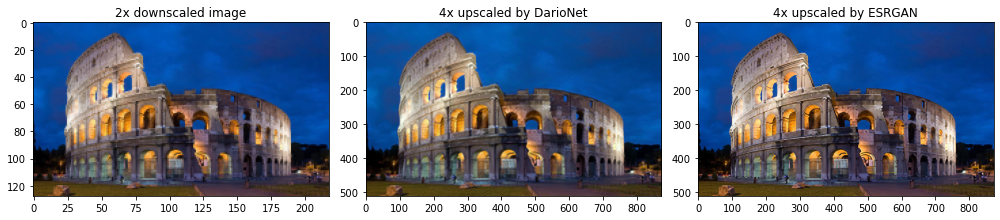

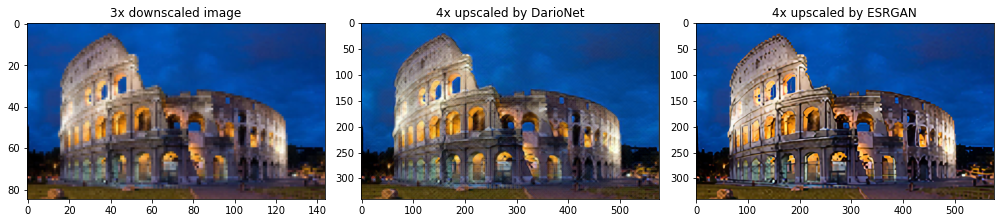

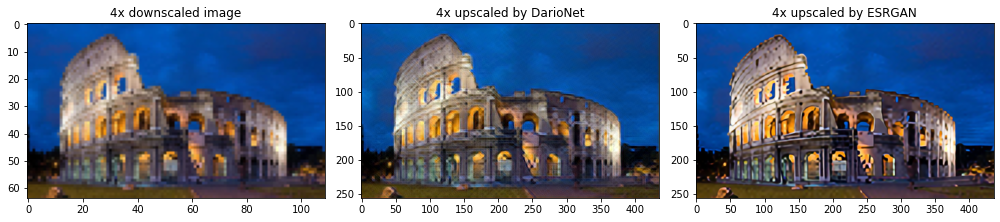

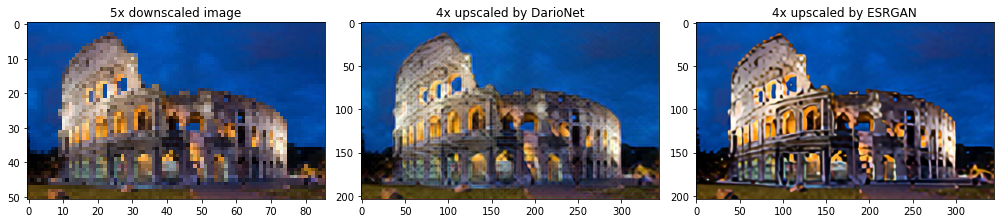

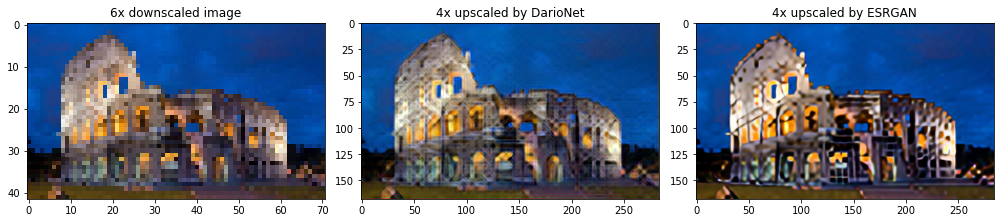

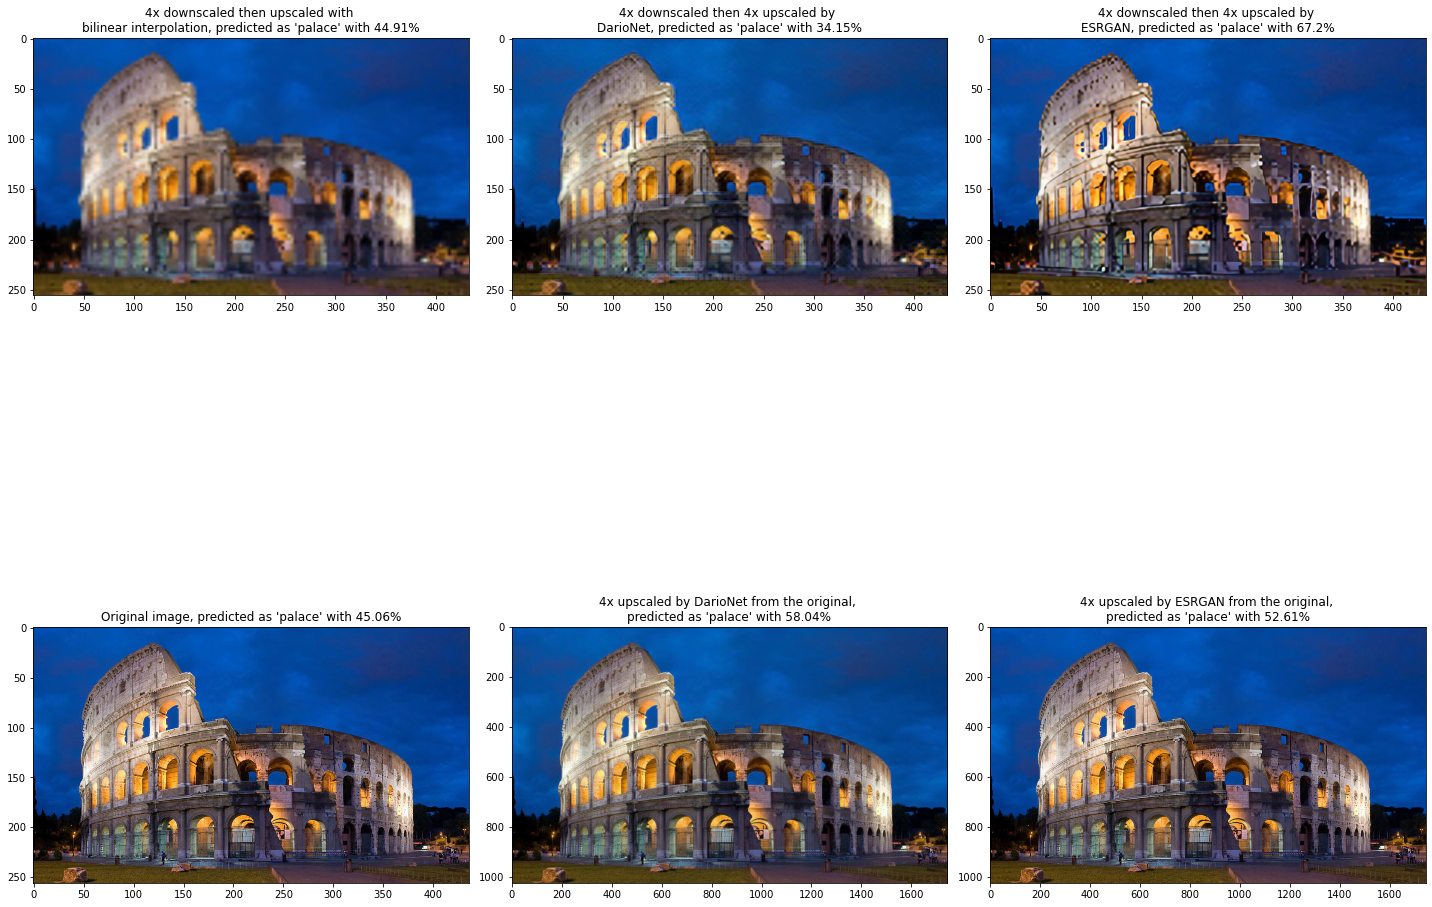

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

img = Image.open(img_path).convert('RGB')

# Images are scaled down to 256 pixel on the shortest side, in order to 
# make a meaningful comparison on the quality of images passed to the classifier.
# The super resolution works without this rescaling, but our hypothesis here
# is to keep from the original image only what's necessary for an accurate
# classification with Resnet. 
img = Scaler(256)(transforms.ToTensor()(img)).to(device)

# In order to make predictions with Resnet, we took CenterCrops of the
# same size of the shortest side. This is necessary so that the filters applied 
# by Resnet in its convolutional layers meet input images with same 
# dimensions.

classifier_transforms = transforms.Compose([transforms.ToPILImage(),
                                            transforms.Resize(256),
                                            transforms.CenterCrop(256),
                                            transforms.ToTensor()
                                            ])
# loads DarioNet
darionet_pretrained_model_path = 'assets/checkpoints/darionet_epoch_0.pt'
RRDB_path = join("assets", "models", "RRDB_PSNR_x4.pth")

# applies the super resolution
darionet = torch.load(darionet_pretrained_model_path).to(device)
rrdb = RRDB(pretrained_weights_path=RRDB_path)

with torch.no_grad():
    for scale in np.linspace(start=2, stop=6, endpoint=True, num=5, dtype=int):
        img_downscaled = Scaler(min(*img.shape[1:]) // int(scale))(img)
        try:
            img_downscaled_super_resolution = darionet(img_downscaled.unsqueeze(dim=0))[0]
            img_downscaled_super_RRDB = rrdb(img_downscaled.unsqueeze(dim=0))[0]
            plot_images_horizontally(imgs=[img_downscaled, img_downscaled_super_resolution, img_downscaled_super_RRDB], 
                                        titles=[f"{scale}x downscaled image", f"4x upscaled by DarioNet", f"4x upscaled by ESRGAN"])
        except Exception as e:
            print(e)
    try:
        # super resolution
        img_4x_downscaled = Scaler(min(*img.shape[1:]) // 3)(img)
        img_4x_downscaled_bilinear_upscale = Scaler(256)(Scaler(min(*img.shape[1:]) //3)(img))
        # Since the images are downscaled only by a factor of 0.32 (so a little less
        # than 3x), but the super resolution with esrgan outputs 4x upscaled images,
        # we downscale again to the size that should be passed to Resnet. So here
        # the 0.32 scale does not produce bigger output images, but is applied 
        # only to keep more details from the original image while downscaling. 
        img_4x_downscaled_super_resolution = Scaler(256)(darionet(img_4x_downscaled.unsqueeze(dim=0))[0])
        img_4x_downscaled_super_RRDB = Scaler(256)(rrdb(img_4x_downscaled.unsqueeze(dim=0))[0])
        
        img_super_resolution = darionet(img.unsqueeze(dim=0))[0]
        img_super_RRDB = rrdb(img.unsqueeze(dim=0))[0]
        # classification
        img_clas = classifier_transforms(img).to(device)
        
        img_4x_downscaled_clas = classifier_transforms(img_4x_downscaled).to(device) 
        img_4x_downscaled_bilinear_clas = classifier_transforms(img_4x_downscaled_bilinear_upscale).to(device)
        
        img_4x_downscaled_super_resolution_clas = classifier_transforms(img_4x_downscaled_super_resolution).to(device)
        img_4x_downscaled_super_RRDB_clas = classifier_transforms(img_4x_downscaled_super_RRDB).to(device)
        
        img_super_resolution_clas = classifier_transforms(img_super_resolution).to(device)
        img_super_RRDB_clas = classifier_transforms(img_super_RRDB).to(device)

        scores_original = torch.nn.functional.softmax(Classifier().eval()(img_clas.unsqueeze(0)).squeeze(), dim=0).detach().cpu()
        scores_reconstructed = torch.nn.functional.softmax(Classifier().eval()(img_4x_downscaled_super_resolution_clas.unsqueeze(0)).squeeze(), dim=0).detach().cpu()
        scores_reconstructed_RRDB = torch.nn.functional.softmax(Classifier().eval()(img_4x_downscaled_super_RRDB_clas.unsqueeze(0)).squeeze(), dim=0).detach().cpu()
        
        scores_downscaled = torch.nn.functional.softmax(Classifier().eval()(img_4x_downscaled_clas.unsqueeze(0)).squeeze(), dim=0).detach().cpu()
        scores_downscaled_bilinear = torch.nn.functional.softmax(Classifier().eval()(img_4x_downscaled_bilinear_clas.unsqueeze(0)).squeeze(), dim=0).detach().cpu()
        
        scores_super_resolution = torch.nn.functional.softmax(Classifier().eval()(img_super_resolution_clas.unsqueeze(0)).squeeze(), dim=0).detach().cpu()
        scores_super_RRDB = torch.nn.functional.softmax(Classifier().eval()(img_super_RRDB_clas.unsqueeze(0)).squeeze(), dim=0).detach().cpu()
        
        label_original = labels[str(torch.argmax(scores_original, dim=0).item())].split(",")[0]
        label_reconstructed = labels[str(torch.argmax(scores_reconstructed, dim=0).item())].split(",")[0]
        label_reconstructed_RRDB = labels[str(torch.argmax(scores_reconstructed_RRDB, dim=0).item())].split(",")[0]
        
        label_downscaled = labels[str(torch.argmax(scores_downscaled, dim=0).item())].split(",")[0]
        label_downscaled_bilinear = labels[str(torch.argmax(scores_downscaled_bilinear, dim=0).item())].split(",")[0]

        label_super_resolution = labels[str(torch.argmax(scores_super_resolution, dim=0).item())].split(",")[0]
        label_super_RRDB = labels[str(torch.argmax(scores_super_RRDB, dim=0).item())].split(",")[0]
        
        plot_images_horizontally(imgs=[img_4x_downscaled_bilinear_upscale, img_4x_downscaled_super_resolution, img_4x_downscaled_super_RRDB, 
                                       img, img_super_resolution, img_super_RRDB], 
                                 titles=[
                                         f"4x downscaled then upscaled with \nbilinear interpolation, predicted as '{label_downscaled_bilinear}' with {np.round(scores_downscaled_bilinear.max().item() * 100, 2)}%",
                                         
                                         f"4x downscaled then 4x upscaled by \nDarioNet, predicted as '{label_reconstructed}' with {np.round(scores_reconstructed.max().item() * 100, 2)}%", 
                                         f"4x downscaled then 4x upscaled by \nESRGAN, predicted as '{label_reconstructed_RRDB}' with {np.round(scores_reconstructed_RRDB.max().item() * 100, 2)}%", 
                                         
                                         f"Original image, predicted as '{label_original}' with {np.round(scores_original.max().item() * 100, 2)}%", 
                                         
                                         f"4x upscaled by DarioNet from the original, \npredicted as '{label_super_resolution}' with {np.round(scores_super_resolution.max().item() * 100, 2)}%",
                                         f"4x upscaled by ESRGAN from the original, \npredicted as '{label_super_RRDB}' with {np.round(scores_super_RRDB.max().item() * 100, 2)}%",
                                         ])
    except Exception as e:
            print(e)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


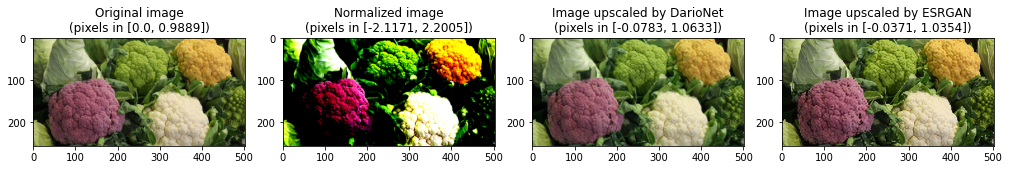

In [48]:
img_normalized = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])(img)
plot_images_horizontally(imgs=[img, img_normalized, img_4x_downscaled_super_resolution, img_4x_downscaled_super_RRDB], 
                        titles=[f"Original image\n(pixels in [{np.round(torch.min(img).item(), 4)}, {np.round(torch.max(img).item(), 4)}])", 
                                f"Normalized image\n(pixels in [{np.round(torch.min(img_normalized).item(), 4)}, {np.round(torch.max(img_normalized).item(), 4)}])",
                                f"Image upscaled by DarioNet\n(pixels in [{np.round(torch.min(img_4x_downscaled_super_resolution).item(), 4)}, {np.round(torch.max(img_4x_downscaled_super_resolution).item(), 4)}])",
                                f"Image upscaled by ESRGAN\n(pixels in [{np.round(torch.min(img_4x_downscaled_super_RRDB).item(), 4)}, {np.round(torch.max(img_4x_downscaled_super_RRDB).item(), 4)}])"])